In [1]:
!pip -q install torch torchvision
!pip -q install transformers datasets
!pip -q install transformers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# PyTorch
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
# Loading dataset
from datasets import load_dataset
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
import time
import argparse
from transformers import TrainingArguments, Trainer
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Compose, Resize, ToTensor, Normalize
from datasets import load_dataset

In [3]:

#Only a small subset of dataset is used for demonstration purpose. Split the data into training, validation and testing datasets
trainds, testds = load_dataset("cifar10", split=["train[:5000]","test[:1000]"])
splits = trainds.train_test_split(test_size=0.2)
trainds = splits['train']
valds = splits['test']

_transf = Compose([
    Resize(224),
    RandomCrop(224, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.16k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [4]:
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

In [5]:
trainds.features, trainds.num_rows, trainds[0]

({'img': Image(mode=None, decode=True, id=None),
  'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)},
 4000,
 {'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  'label': 8,
  'pixels': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -0.6794, -0.6794, -0.6794],
           [-2.1179, -2.1179, -2.1179,  ..., -0.6965, -0.6965, -0.6965],
           [-2.1179, -2.1179, -2.1179,  ..., -0.6965, -0.6965, -0.6965]],
  
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.03

In [6]:
#Now let’s map the integer labels to string labels and vice-versa.
itos = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
itos

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

ship


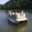

In [7]:
#Now, let’s display an image and corresponding label from the dataset.
index = 0
img, lab = trainds[index]['img'], itos[trainds[index]['label']]
print(lab)
img

In [8]:

from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn as nn

model_checkpoint = "google/efficientnet-b0"

# Load processor
processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# Load model with original head (1000 classes)
model = AutoModelForImageClassification.from_pretrained(model_checkpoint)

# Replace the classifier head with a new one for CIFAR-10 (10 classes)
model.classifier = nn.Linear(model.classifier.in_features, 10)


preprocessor_config.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [9]:
from torchvision.transforms import Normalize

mu = [0.485, 0.456, 0.406]
sigma = [0.229, 0.224, 0.225]

norm = Normalize(mean=mu, std=sigma) #normalize image pixels range to [-1,1]

# Set image size
size = {'height': 224, 'width': 224}

# resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
])

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

In [10]:
#Apply the transformations to each dataset.
trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

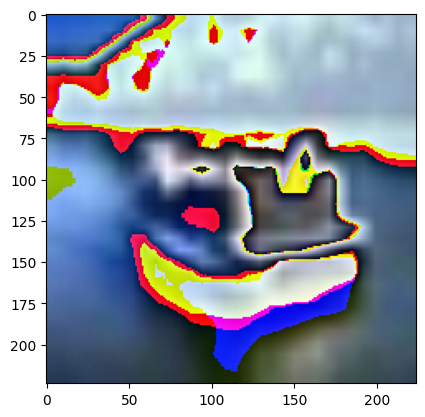

In [11]:
#To view a transformed image, run the following code snippet
idx = 0
ex = trainds[idx]['pixels']
ex = (ex+1)/2 #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

In [12]:
#We use Hugging Face’s AutoModelForImageClassification which takes images as input and outputs the predictions of classes.
#Let’s first see what the original model’s classifier looks like.

model_name = "google/efficientnet-b0"
model = AutoModelForImageClassification.from_pretrained(model_name)
print(model.classifier)

Linear(in_features=1280, out_features=1000, bias=True)


In [13]:
"""
It outputs probabilities for 1000 classes as it should because it was originally fine-tuned on ImageNet-1k.

We can fine tune it to output 10 classes using the following parameters: num_labels which basically changes the number of nodes in final linear layer,
ignore_mismatched_sizes because originally it would have 1000 output nodes but now we’ll just have 10, and the mapping of label indices and label strings.
"""

model = AutoModelForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Some weights of EfficientNetForImageClassification were not initialized from the model checkpoint at google/efficientnet-b0 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1280]) in the checkpoint and torch.Size([10, 1280]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=1280, out_features=10, bias=True)


In [14]:
"""
Trainer provides a high level of abstraction and simplifies the training and evaluation.

Let’s start of with training arguments where you can define hyperparameters, logging, metrics, etc.
"""
args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=1e-4,  # Increased learning rate
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=15,  # More epochs
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
    save_total_limit=1,  # Only the best checkpoins
    lr_scheduler_type="cosine"  # Decline in learning rate
)

In [15]:

"""
Now, we need a collate function that is used in data loading. It stacks pixel values into a tensor and creates a tensor for labels. The model needs pixel_values and labels in a batch of inputs so do not change the names of these tensors.

We also need a function to compute metrics. In our case, we’ll use accuracy. I recommend passing a sample input into these functions and printing the values to better understand them.
"""

def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [16]:
trainer = Trainer(
    model,
    args,
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

<ipython-input-16-f97f2f043566>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [17]:
"""
We have to train the last layer that we fine-tuned while keeping all other layers freezed. Do this by simply calling:
"""

trainer.train()


"""

5cad00af373791f4dec51990688c36eb571934a7

"""

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kayadeniz2001 (kayadeniz2001-maastricht-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.611679,0.791000
2,1.103800,0.406580,0.869000
3,0.428200,0.384359,0.882000
4,0.248100,0.406822,0.884000
5,0.156100,0.590579,0.855000
6,0.156100,0.508513,0.866000
7,0.098600,0.560926,0.866000
8,0.069900,0.615556,0.858000
9,0.039400,0.482396,0.891000
10,0.038400,0.519123,0.887000


'\n\n5cad00af373791f4dec51990688c36eb571934a7\n\n'

In [18]:
outputs = trainer.predict(testds)
print(outputs.metrics)

{'test_loss': 0.33638060092926025, 'test_accuracy': 0.916, 'test_runtime': 4.5515, 'test_samples_per_second': 219.706, 'test_steps_per_second': 54.926}


In [19]:
itos[np.argmax(outputs.predictions[0])], itos[outputs.label_ids[0]]

('cat', 'cat')

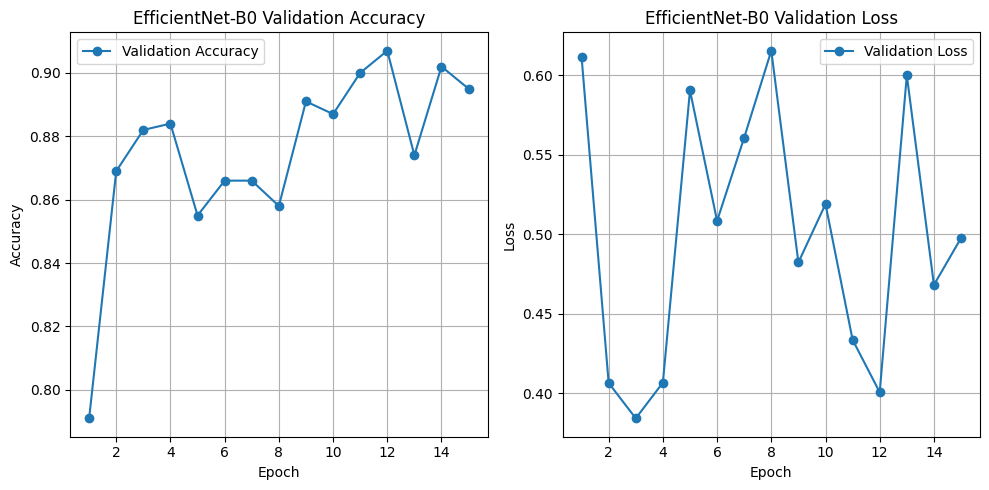

In [33]:
import matplotlib.pyplot as plt

epochs = range(1, 16)
val_accuracy = [0.791, 0.869, 0.882, 0.884, 0.855, 0.866, 0.866, 0.858, 0.891, 0.887, 0.900, 0.907, 0.874, 0.902, 0.895]
val_loss = [0.611679, 0.406580, 0.384359, 0.406822, 0.590579, 0.508513, 0.560926, 0.615556, 0.482396, 0.519123, 0.433747, 0.400743, 0.600123, 0.468277, 0.497740]

plt.figure(figsize=(10, 5))

# Validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EfficientNet-B0 Validation Accuracy')
plt.legend()
plt.grid(True)

# Validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNet-B0 Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('efficientnet_training_plot.png')
plt.show()

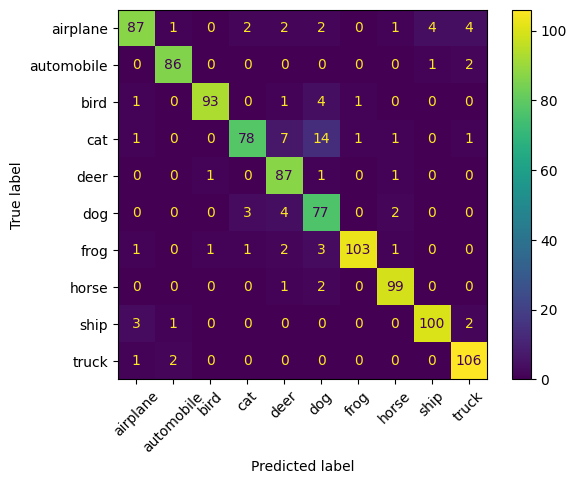

In [21]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = trainds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [22]:
!ls test-cifar-10

checkpoint-4800


In [25]:
model_name = "google/efficientnet-b0"
# processor = ViTImageProcessor.from_pretrained(model_name) # This line is incorrect, as you are using an EfficientNet model

# Load the model from the local directory
# Use AutoModelForImageClassification instead of ViTForImageClassification
model = AutoModelForImageClassification.from_pretrained(
    "/content/test-cifar-10/checkpoint-4800",  # Path to your locally saved model
    num_labels=10,
    ignore_mismatched_sizes=True,
    local_files_only=True  # This tells the function to only look for local files
)

model.to('cpu') #Run the model on CPU
model.eval()
print("Model loaded on CPU!!")

Model loaded on CPU!!


In [26]:
processor = AutoImageProcessor.from_pretrained("google/efficientnet-b0")

# Get an image from the test data set
testds = load_dataset("cifar10", split="test[:1000]")
sample_image = testds[0]['img']
itos = dict((k, v) for k, v in enumerate(testds.features['label'].names))

# Process the image
transform = Compose([
    Resize(224),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])
pixel_values = transform(sample_image.convert('RGB')).unsqueeze(0).to('cpu')

# Predict
with torch.no_grad():
    outputs = model(pixel_values)
predicted_class = outputs.logits.argmax(-1).item()
print(f"Predicted class: {itos[predicted_class]}")
print(f"Actual class: {itos[testds[0]['label']]}")

Predicted class: cat
Actual class: cat


In [27]:
# Load the dataset
testds = load_dataset("cifar10", split="test[:1000]")
itos = dict((k, v) for k, v in enumerate(testds.features['label'].names))

# Preprocessing
transform = Compose([
    Resize(224),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

# Inference loop
start_time = time.time()
predictions = []
true_labels = []
for example in testds:
    image = example['img']
    label = example['label']
    pixel_values = transform(image.convert('RGB')).unsqueeze(0).to('cpu')
    with torch.no_grad():
        outputs = model(pixel_values)
    pred = outputs.logits.argmax(-1).item()
    predictions.append(pred)
    true_labels.append(label)

# Metrices
accuracy = np.mean(np.array(predictions) == np.array(true_labels))
inference_time = time.time() - start_time

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total Inference Time (GPU): {inference_time:.2f} seconds")
print(f"Average Inference Time per Image: {inference_time / len(testds):.4f} seconds")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

Test Accuracy: 0.8840
Total Inference Time (GPU): 26.05 seconds
Average Inference Time per Image: 0.0260 seconds
Model Parameters: 4,020,358


In [28]:
%%writefile inference.py

def load_model(checkpoint_path):
    model_name = "google/efficientnet-b0"
    processor = AutoModelForImageClassification.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        checkpoint_path,
        num_labels=10,
        ignore_mismatched_sizes=True
    )
    model.to('cpu')
    model.eval()
    return model, processor

def inference(image, model, processor):
    transform = Compose([
        Resize(224),
        ToTensor(),
        Normalize(mean=processor.image_mean, std=processor.image_std)
    ])
    pixel_values = transform(image.convert('RGB')).unsqueeze(0).to('cpu')
    with torch.no_grad():
        outputs = model(pixel_values)
    return outputs.logits.argmax(-1).item()

def main():
    parser = argparse.ArgumentParser(description="Inference on CIFAR-10")
    parser.add_argument("--checkpoint", required=True, help="Path to model checkpoint")
    args = parser.parse_args()

    # Load the model
    model, processor = load_model(args.checkpoint)

    # Load the dataset
    testds = load_dataset("cifar10", split="test[:1000]")
    itos = dict((k, v) for k, v in enumerate(testds.features['label'].names))

    # Inference
    start_time = time.time()
    predictions = []
    true_labels = []
    for example in testds:
        image = example['img']
        label = example['label']
        pred = inference(image, model, processor)
        predictions.append(pred)
        true_labels.append(label)

    # Metrices
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    inference_time = time.time() - start_time
    param_count = sum(p.numel() for p in model.parameters())

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Total Inference Time (CPU): {inference_time:.2f} seconds")
    print(f"Average Inference Time per Image: {inference_time / len(testds):.4f} seconds")
    print(f"Model Parameters: {param_count:,}")

if __name__ == "__main__":
    main()

Writing inference.py


In [32]:
##Download the checkpoints as a zip file
from google.colab import files
!zip -r checkpoint-efficientnet-checkpoint.zip /content/test-cifar-10/checkpoint-4800
files.download("checkpoint-efficientnet-checkpoint.zip")

updating: content/test-cifar-10/checkpoint-4800/ (stored 0%)
updating: content/test-cifar-10/checkpoint-4800/config.json (deflated 61%)
updating: content/test-cifar-10/checkpoint-4800/rng_state.pth (deflated 25%)
updating: content/test-cifar-10/checkpoint-4800/model.safetensors (deflated 7%)
updating: content/test-cifar-10/checkpoint-4800/training_args.bin (deflated 52%)
updating: content/test-cifar-10/checkpoint-4800/optimizer.pt (deflated 8%)
updating: content/test-cifar-10/checkpoint-4800/trainer_state.json (deflated 75%)
updating: content/test-cifar-10/checkpoint-4800/preprocessor_config.json (deflated 50%)
updating: content/test-cifar-10/checkpoint-4800/scheduler.pt (deflated 55%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>